In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click here to toggle on/off the raw code.">
</form>''')

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import time
pd.set_option('display.max_colwidth', None)

# Trust in Law Enforcement: Understanding the Drivers of Police Sentiment Scores

###  **1.0 Highlights**

- The intent of the study is to understand the drivers of police sentiment scores.
- Many datasets were used, covering geography, race, socio-economics, crime, and even public health.
- Repeated KFold cross-validation was successful in increasing accuracy given limited observations.
- For educational purposes, sklearn’s Pipeline and GridSearchCV modules were studied and used.
- Unemployment, `Pop_White`, and Longitude were good predictors of trust in police.

### **2.0 Introduction and Motivation for the Study**

The objective of this study is to build a would model that would predict the results of a police sentiment survey, identifying to what degree a community trusts their police force, and feels that their local law enforcement treats them with respect. Much attention has been brought to this issue in the US, with controversies surrounding the Black Lives Matter movement and police brutality, however it’s not only relevant in the US. This may be considered important in other countries as well, to guide law enforcement on how to build trust and rapport within their communities.

Considering the subject matter, more than simply building an accurate model, another key objective is interpretability. What elements in a community leads to greater trust in police? Is it crime rates? Per capita wealth? How about the proportion of racial minorities? Emphasis would be placed in conducting research to combine multiple datasets with as many relevant features as possible into the design matrix, so as to capture the top drivers of police sentiment scores

The study would focus on community areas in the city of Chicago, and different regressors will be trained and tested to come up with a predictive model.

### **3.0 Data Cleaning and Pre-Processing**

As with any machine learning project, one of the first steps is to gather and consolidate the data. For this particular study, multiple datasets were downloaded, many of them from the Chicago Data Portal, then examined and cleaned one by one.

**Socio-economic Data**

In [3]:
# Load socioeconomic data
df_socio = pd.read_csv('Features - socioeconomic.csv')

# Display column types and null value counts
display(pd.concat([df_socio.dtypes, df_socio.isnull().sum()], axis=1).
        rename(columns={0:'dtype', 1:'NaN'}))

,dtype,NaN
COMMUNITY_AREA_NUMBER,int64,0
COMMUNITY_AREA_NAME,object,0
PERCENT OF HOUSING CROWDED,float64,0
PERCENT HOUSEHOLDS BELOW POVERTY,float64,0
PERCENT AGED 16+ UNEMPLOYED,float64,0
PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,float64,0
PERCENT AGED UNDER 18 OR OVER 64,float64,0
PER_CAPITA_INCOME,int64,0
HARDSHIP_INDEX,int64,0


Fortunately, there are no null values and the data requires relatively little cleaning. We need only convert the column headers to titlecase for aesthetic purposes and consistency with other datasets.

In [4]:
# Convert column headers to titlecase
df_socio.columns = df_socio.columns.str.title()

df_socio.head()

,Community_Area_Number,Community_Area_Name,Percent Of Housing Crowded,Percent Households Below Poverty,Percent Aged 16+ Unemployed,Percent Aged 25+ Without High School Diploma,Percent Aged Under 18 Or Over 64,Per_Capita_Income,Hardship_Index
0,1,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39
1,2,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46
2,3,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20
3,4,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17
4,5,North Center,0.3,7.5,5.2,4.5,26.2,57123,6


**Geographic Data**

Next, we load geographic data. Once more, we observe tha minimal cleaning is required.

In [5]:
# Load geographic data
df_geog = pd.read_csv('Features - geographic.csv')

# Display column types and null value counts
display(pd.concat([df_geog.dtypes, df_geog.isnull().sum()], axis=1).
        rename(columns={0:'dtype', 1:'NaN'}))

,dtype,NaN
COMMUNITY_AREA_NUMBER,int64,0
COMMUNITY_AREA_NAME,object,0
Area_sqkm,float64,0
Latitude,float64,0
Longitude,float64,0


In [6]:
# Convert column headers to titlecase.
df_geog.columns = df_geog.columns.str.title()

df_geog.head()

,Community_Area_Number,Community_Area_Name,Area_Sqkm,Latitude,Longitude
0,1,Rogers Park,4.77,42.011937,-87.670152
1,2,West Ridge,9.14,41.999557,-87.693110
2,3,Uptown,6.01,41.966053,-87.657373
3,4,Lincoln Square,6.63,41.972285,-87.689206
4,5,North Center,5.31,41.947516,-87.683101


**Crime Data**

Next, we load data on crime reports.

In [7]:
# Load crime data
df_crime = pd.read_csv('Features - crime 2020.csv')
display(pd.concat([df_crime.dtypes, df_crime.isnull().sum()], axis=1).
        rename(columns={0:'dtype', 1:'NaN'}))

,dtype,NaN
ID,int64,0
Case Number,object,0
Date,object,0
Block,object,0
IUCR,object,0
Primary Type,object,0
Description,object,0
Location Description,object,1193
Arrest,bool,0
Domestic,bool,0


Here, we see the data is much more vast, listing a year's worth of crime reports. However, we only need the aggregated statistics in terms of crime volume per community. So we can discard most of the columns (including those with null values) and apply the `groupby` method to get the 2020 reported crime count per Community Area.

In [8]:
# Retrieve only crime count per community area
df_crime = df_crime.groupby('Community Area')[['ID']].count().reset_index()

# Rename columns
df_crime.columns = ['Community_Area_Number', 'Crimes']

# Convert Community Area column to integer type
df_crime['Community_Area_Number'] = df_crime['Community_Area_Number'].astype(int)

df_crime.head()

,Community_Area_Number,Crimes
0,1,3279
1,2,3089
2,3,2936
3,4,1879
4,5,1148


**Demographic Data**

Next, we load demographic data, consisting primarily of data on population count per racial group, and housing statistics.

In [9]:
# Load demographic data on ethnicity and housing
df_demog = pd.read_csv('Features - ethnicity and housing.csv')

display(pd.concat([df_demog.dtypes, df_demog.isnull().sum()], axis=1).
        rename(columns={0:'dtype', 1:'NaN'}))

,dtype,NaN
COMMUNITY_AREA_NUMBER,int64,0
COMMUNITY_AREA_NAME,object,0
Pop_Total,int64,0
Pop_Households,int64,0
Pop_GroupQuarters,int64,0
Pop_Hispanic,int64,0
Pop_White,int64,0
Pop_Black,int64,0
Pop_Asian,int64,0
Pop_Other,int64,0


Again, there are no missing values to be imputed, and all the data aside from the community names appear to be numerical. However, closer observation shows that the the dataset features total population counts per racial group, as well as the total number of occupied and vacant housing units. This needs to be normalized, since clearly a large community will always have more people belonging to each minority group, and more housing units as well. Hence we modify the columns accordingly.

Note however that we will retain the total population count and total housing unit count, in case the size of a community has any bearing on the target variable.

In [10]:
# Convert column headers to titlecase
df_demog.columns = df_demog.columns.str.title()

# Express population counts per segment (per housing type and ethnicity)
# as proportions of total population
df_demog.iloc[:, 3:10] = df_demog.iloc[:, 3:10].to_numpy() / df_demog[['Pop_Total']].to_numpy()

# Express housing type counts as proportion of total housing units
df_demog.iloc[:, 11:13] = df_demog.iloc[:, 11:13].to_numpy() / df_demog[['Housing_Units']].to_numpy()

# Drop columns column on occupied housing units, since it is perfectly
# negatively correlated related to vacant housing units
df_demog = df_demog.drop(['Hu_Occupied'], axis=1)

# Drop columns column on population living in households, since it is perfectly
# negatively correlated to the population living in group quarters
df_demog = df_demog.drop(['Pop_Households'], axis=1)

df_demog.head()

,Community_Area_Number,Community_Area_Name,Pop_Total,Pop_Groupquarters,Pop_Hispanic,Pop_White,Pop_Black,Pop_Asian,Pop_Other,Housing_Units,Hu_Vacant,Ave_Household_Size
0,1,Rogers Park,55628,0.060869,0.226271,0.400733,0.248418,0.068670,0.055907,28531,0.074621,1.978714
1,2,West Ridge,77122,0.020630,0.198478,0.365810,0.135940,0.256931,0.042841,28249,0.062161,2.850980
2,3,Uptown,57182,0.036725,0.132682,0.522385,0.188871,0.108111,0.047952,35019,0.080071,1.709825
3,4,Lincoln Square,40494,0.012965,0.174569,0.625821,0.039537,0.111523,0.048550,20431,0.063041,2.087917
4,5,North Center,35114,0.001595,0.128239,0.734721,0.022213,0.061571,0.053255,15936,0.063065,2.348001


**Public Health Data**

Finally, we load the public health indicators.

In [11]:
# Load public health data
df_health = pd.read_csv('Features - public health.csv')

# Display column types and null value counts
display(pd.concat([df_health.dtypes, df_health.isnull().sum()], axis=1).
        rename(columns={0:'dtype', 1:'NaN'}))

,dtype,NaN
Community_Area_Number,int64,0
Community_Area_Name,object,0
Birth Rate,float64,0
Nat_General Fertility Rate,float64,0
Nat_Low Birth Weight,float64,0
Nat_Prenatal Care Beginning in First Trimester,float64,0
Nat_Preterm Births,float64,0
Nat_Teen Birth Rate,float64,0
Mort_Assault (Homicide),float64,0
Mort_Breast cancer in females,float64,0


Here we can see that there are numerous features, a number of them redundant with socio-economic data loaded previously. Also, many of the features are unlikely to have any relevance to the topic at hand; for instance the infection rates of gonnerhea in females would very likely have no bearing on police sentiment scores (any correlation would likely be spurious, and certainly uninterpretable). Hence we drop these columns, including those with missing values. We apply our judgement and perform feature selection, retaining only data on overall birth rates, teen birth/pregnancy rates, and mortality rates related to assault and firearms.

In [12]:
# Perform feature engineering by retaining only columns that 
# may have possible relevance to police sentiment scores. Exclude
# also columns that are redundant with previously loaded socio-economic data.
df_health = df_health[['Community_Area_Number', 'Community_Area_Name',
                       'Birth Rate', 'Nat_Teen Birth Rate',
                       'Mort_Assault (Homicide)', 'Mort_Firearm-related']]
df_health.head()

,Community_Area_Number,Community_Area_Name,Birth Rate,Nat_Teen Birth Rate,Mort_Assault (Homicide),Mort_Firearm-related
0,1,Rogers Park,16.4,40.8,7.7,5.2
1,2,West Ridge,17.3,29.9,5.8,3.7
2,3,Uptown,13.1,35.1,5.4,4.6
3,4,Lincoln Square,17.1,38.4,5.0,6.1
4,5,North Center,22.4,8.4,1.0,1.0


**Data Consolidation**

Finally, we consolidate all the disparate datasets into one design matrix, and set the Community Area Name and Number as the index.

In [13]:
# Put all the data together in one design matrix

df_all = df_geog.copy()
df_all = df_all.merge(df_socio.drop('Community_Area_Name', axis=1),
                      on='Community_Area_Number')
df_all = df_all.merge(df_crime, on='Community_Area_Number')
df_all = df_all.merge(df_demog.drop('Community_Area_Name', axis=1),
                      on='Community_Area_Number')
df_all = df_all.merge(df_health.drop('Community_Area_Name', axis=1),
                      on='Community_Area_Number')
df_all = df_all.set_index(df_all['Community_Area_Number'].astype(str)
                          + ' - '
                          + df_all['Community_Area_Name'])
df_all = df_all.drop(['Community_Area_Number', 'Community_Area_Name'], axis=1)
df_all

,Area_Sqkm,Latitude,Longitude,Percent Of Housing Crowded,Percent Households Below Poverty,Percent Aged 16+ Unemployed,Percent Aged 25+ Without High School Diploma,Percent Aged Under 18 Or Over 64,Per_Capita_Income,Hardship_Index,...,Pop_Black,Pop_Asian,Pop_Other,Housing_Units,Hu_Vacant,Ave_Household_Size,Birth Rate,Nat_Teen Birth Rate,Mort_Assault (Homicide),Mort_Firearm-related
1 - Rogers Park,4.77,42.011937,-87.670152,7.7,23.6,8.7,18.2,27.5,23939,39,...,0.248418,0.068670,0.055907,28531,0.074621,1.978714,16.4,40.8,7.7,5.2
2 - West Ridge,9.14,41.999557,-87.693110,7.8,17.2,8.8,20.8,38.5,23040,46,...,0.135940,0.256931,0.042841,28249,0.062161,2.850980,17.3,29.9,5.8,3.7
3 - Uptown,6.01,41.966053,-87.657373,3.8,24.0,8.9,11.8,22.2,35787,20,...,0.188871,0.108111,0.047952,35019,0.080071,1.709825,13.1,35.1,5.4,4.6
4 - Lincoln Square,6.63,41.972285,-87.689206,3.4,10.9,8.2,13.4,25.5,37524,17,...,0.039537,0.111523,0.048550,20431,0.063041,2.087917,17.1,38.4,5.0,6.1
5 - North Center,5.31,41.947516,-87.683101,0.3,7.5,5.2,4.5,26.2,57123,6,...,0.022213,0.061571,0.053255,15936,0.063065,2.348001,22.4,8.4,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73 - Washington Heights,7.41,41.719433,-87.649769,1.1,16.9,20.8,13.7,42.6,19713,48,...,0.951486,0.001237,0.021783,10451,0.087360,2.610715,12.0,65.0,38.0,35.6
74 - Mount Greenwood,7.02,41.694318,-87.708096,1.0,3.4,8.7,4.3,36.8,34381,16,...,0.040423,0.006227,0.027324,7298,0.061387,2.668613,12.5,7.7,2.2,7.4
75 - Morgan Park,8.55,41.689622,-87.663627,0.8,13.2,15.0,10.8,40.3,27149,30,...,0.644246,0.003446,0.031247,8865,0.077834,2.524281,13.2,46.7,19.9,15.8
76 - O'Hare,34.55,41.976592,-87.878130,3.6,15.4,7.1,10.9,30.3,25828,24,...,0.028693,0.145923,0.030481,6560,0.061280,2.177168,15.8,15.9,5.6,11.8


As good practice, we compute descriptive statistics on the dataset. This will provide insight later on for how we might further pre-process the data, especially with regard to scaling.

In [14]:
# Summarize the data
df_all.describe()

,Area_Sqkm,Latitude,Longitude,Percent Of Housing Crowded,Percent Households Below Poverty,Percent Aged 16+ Unemployed,Percent Aged 25+ Without High School Diploma,Percent Aged Under 18 Or Over 64,Per_Capita_Income,Hardship_Index,...,Pop_Black,Pop_Asian,Pop_Other,Housing_Units,Hu_Vacant,Ave_Household_Size,Birth Rate,Nat_Teen Birth Rate,Mort_Assault (Homicide),Mort_Firearm-related
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,...,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,7.763766,41.839419,-87.674538,4.923377,21.766234,15.372727,20.341558,35.746753,25563.168831,49.506494,...,0.368401,0.065467,0.029328,16397.558442,0.094825,2.527401,15.698701,50.064935,18.068831,16.731169
std,5.108717,0.098939,0.068640,3.682887,11.529957,7.543412,11.823152,7.327716,15293.098259,28.690556,...,0.382458,0.110733,0.013126,13318.328338,0.044187,0.489419,3.528735,28.097817,16.561077,14.462222
min,1.500000,41.655743,-87.878130,0.300000,3.300000,4.700000,2.500000,13.500000,8201.000000,1.000000,...,0.005380,0.000794,0.005941,1192.000000,0.034383,1.556212,9.400000,1.300000,0.000000,1.000000
25%,4.610000,41.762572,-87.718676,2.300000,13.200000,9.200000,11.800000,32.000000,15754.000000,25.000000,...,0.037447,0.002885,0.020046,7298.000000,0.062161,2.186270,12.900000,33.700000,4.900000,5.500000
50%,7.410000,41.830268,-87.668505,3.800000,18.900000,13.900000,18.500000,38.100000,21323.000000,50.000000,...,0.135940,0.020969,0.026564,12772.000000,0.085273,2.501150,15.700000,49.200000,10.800000,10.600000
75%,9.190000,41.926836,-87.624026,6.800000,29.200000,20.000000,26.600000,40.500000,28887.000000,74.000000,...,0.815681,0.080920,0.038321,20431.000000,0.122628,2.785216,18.500000,67.900000,32.200000,25.800000
max,34.550000,42.011937,-87.534985,15.800000,56.500000,35.900000,54.800000,51.500000,88669.000000,98.000000,...,0.954746,0.722318,0.061753,77429.000000,0.239902,3.816092,22.400000,116.900000,70.300000,70.300000


**Feature Scaling**

The descriptive statistics makes it clear that many of the features have dissimilar scales. To avoid features dominating over the others, feature scaling will be performed. It can be observed that many of the features are bound data, particularly those expressed as percentages, however some data are heavily skewed by outliers; for instance Per Capita Income. To strike a balance between these distributions, RobustScaling will be used, and will be built into the pipelines when the models are cosntructed (except for the Decision Tree-related models, which are scale-invariant).

**Target Data: Police Sentiment Scores**

Having gathered the data related to the predictor variables, we still need to put together the data for the target variable. Hence we load data on police sentiment scores.

In [15]:
# Load target data on police sentiment scores
df_targets = pd.read_csv('Target - Police sentiment.csv')

display(pd.concat([df_targets.dtypes, df_targets.isnull().sum()], axis=1).
        rename(columns={0:'dtype', 1:'NaN'}))

,dtype,NaN
COMMUNITY_AREA_NUMBER,int64,0
COMMUNITY_AREA_NAME,object,0
Police District,object,0
Safety_Score,float64,0
Trust_Score,float64,0


Luckily, we see again that minimal cleaning is needed. One column, the Police District, is redundant since we already know the Community Area, hence it may be dropped.

In [16]:
# Convert column headers to titlecase
df_targets.columns = df_targets.columns.str.title()

# Drop redundant column
df_targets = df_targets.drop('Police District', axis=1)

# Set index
df_targets = df_targets.set_index(df_targets['Community_Area_Number'].astype(str)
                                  + ' - '
                                  + df_targets['Community_Area_Name'])
df_targets = df_targets.drop(['Community_Area_Number', 'Community_Area_Name'], axis=1)

df_targets.head()

,Safety_Score,Trust_Score
1 - Rogers Park,63.229,64.549
2 - West Ridge,63.229,64.549
3 - Uptown,66.875,67.906
4 - Lincoln Square,67.803,66.445
5 - North Center,66.875,67.906


### **4.0 Data Exploration**

Having consolidated the data, we move on to data exploration and visualization. Since there are a lot of features to consider, we can look at the different component feature sets one by one.

First, we examine the target dataset using a pairplot and correlation heatmap. The police sentiment survey actually provides two different scores, a `Safety Score` and `Trust Score`. For this study, we are interested mainly the the Trust Score, which corresponds to how a community feels that their law enforcement are trustworthy, respectful, and concerned (the Safety Score relates to how safe an individual feels in their community). However it is interesting to see that the two scores appear highly correlated, hence the predictors for one score may also be good predictors for the other.

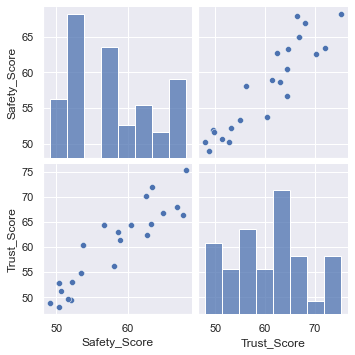

In [17]:
sns.set(style="darkgrid")
sns.pairplot(df_targets)
plt.show()

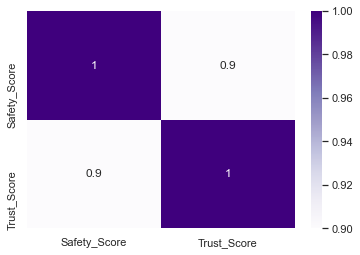

In [18]:
sns.heatmap(df_targets.corr().round(2), cmap='Purples', annot=True)
plt.show()

Next, we examine the socio-economic features using a pairplot and correlation heatmaps. We see that many of the features are indeed quite highly correlated. This stands to reason, since lower income in a community is likely to be an indicator of other socio-economic problems, such as poverty, unemployment, poor education, or overcrowding.

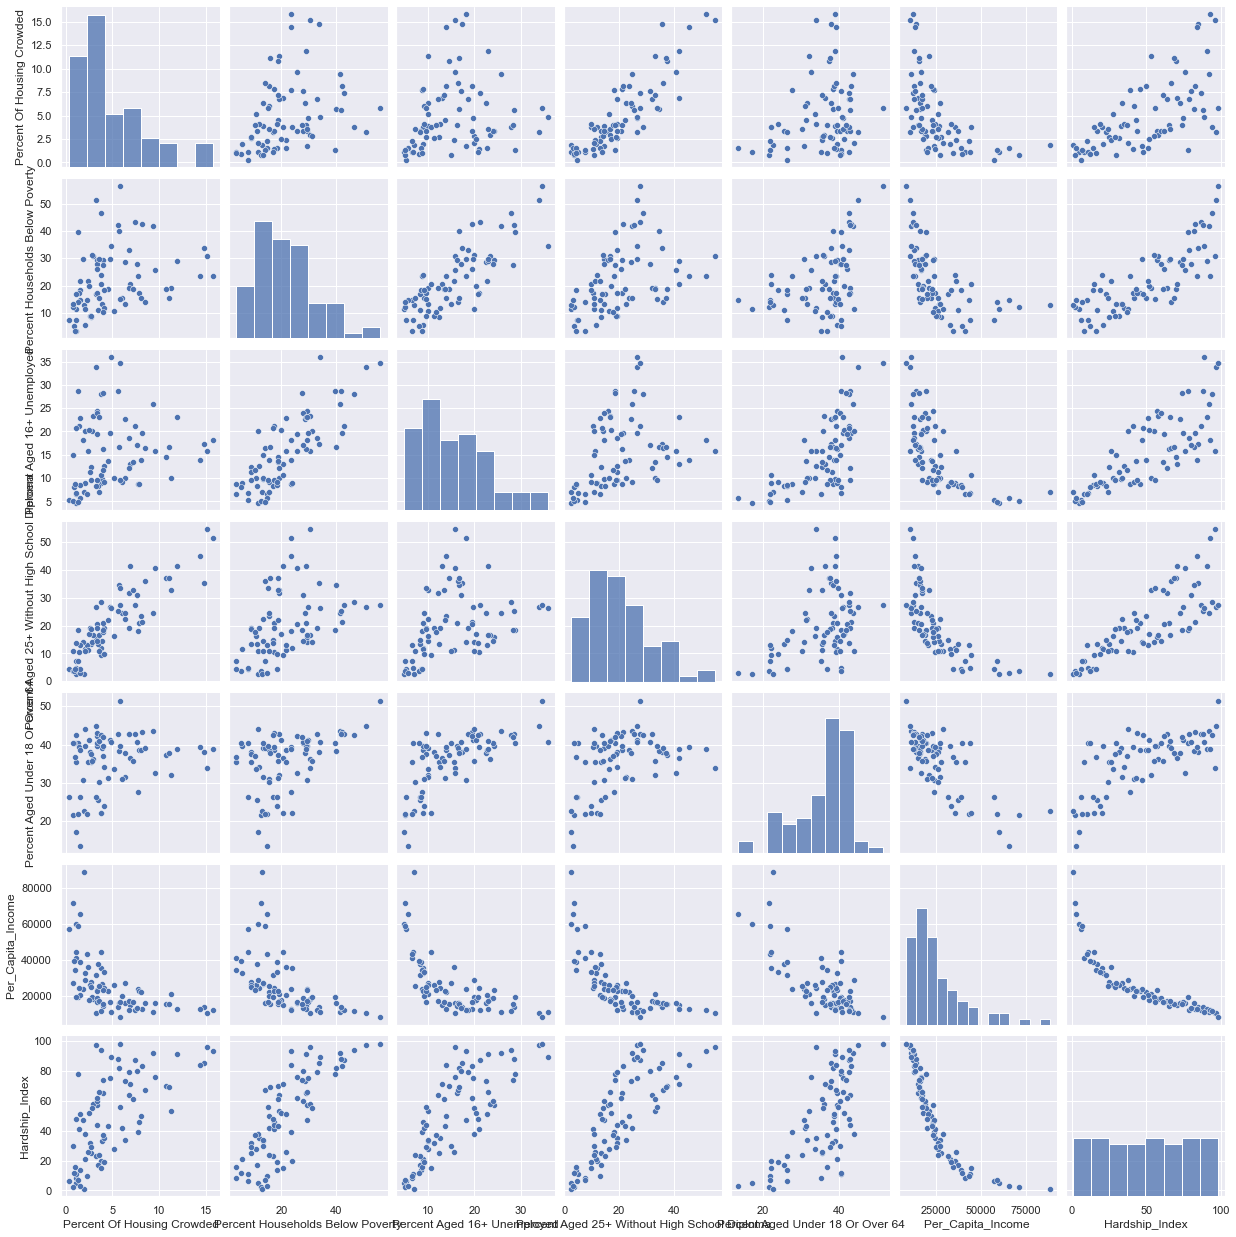

In [19]:
sns.set(style="darkgrid")
sns.pairplot(df_socio.set_index(['Community_Area_Number',
                                 'Community_Area_Name']))
plt.show()

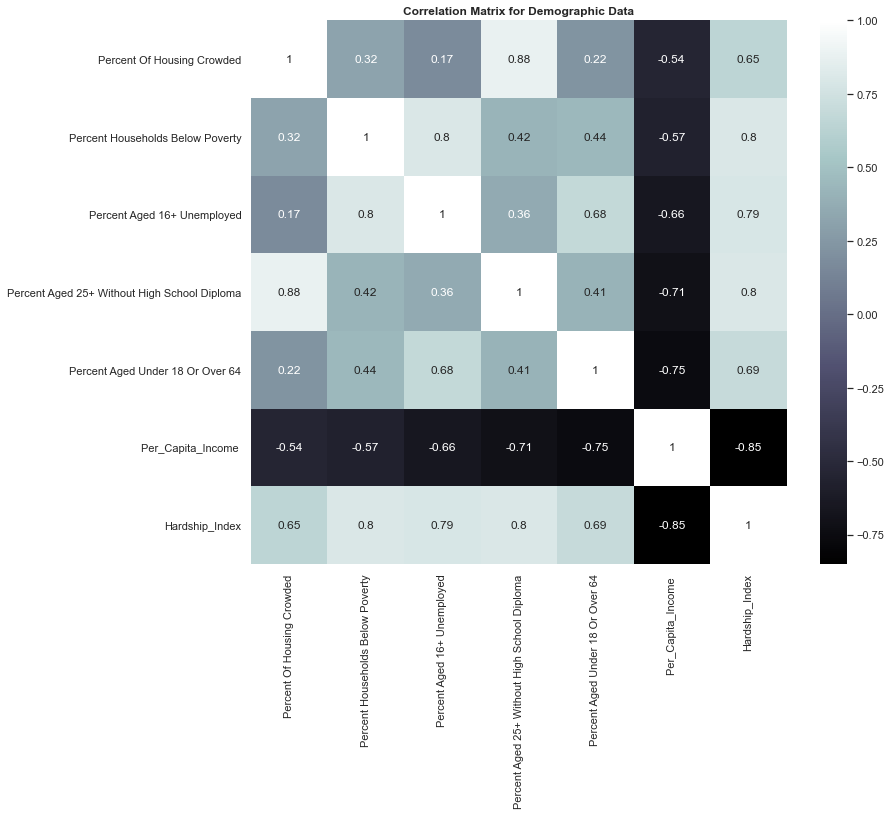

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))
fig = sns.heatmap(df_socio.set_index(['Community_Area_Number',
                                      'Community_Area_Name']).
                  corr().round(2), cmap='bone', annot=True, ax=ax)
fig.set_title('Correlation Matrix for Demographic Data', weight='bold')
plt.show()

Another feature set we would like to examine more closely is the demographic data. There appear to be some interesting patterns, such as there appears to be only few Asians in Chicago in most of the Community Areas, and the Hispanic population seems to be positive colleralted with Average Household Size.

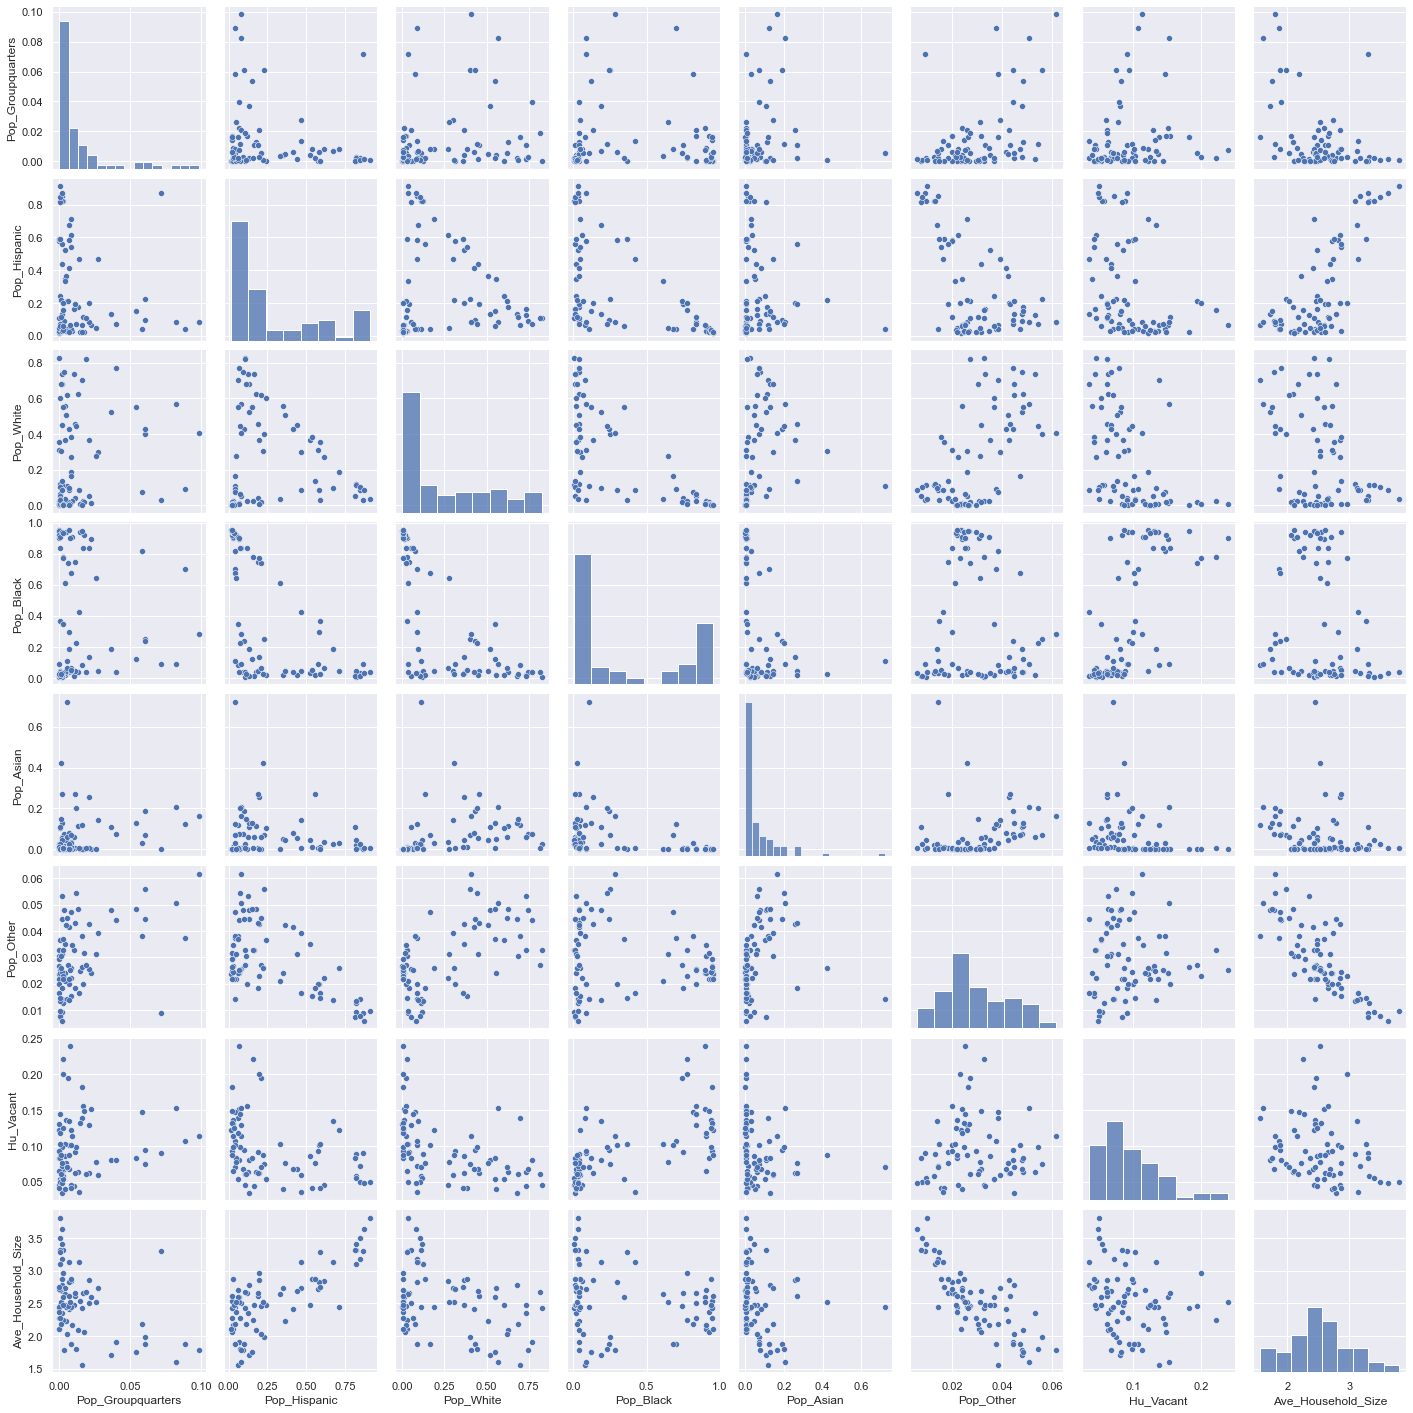

In [21]:
sns.set(style="darkgrid")
sns.pairplot(df_demog.set_index(['Community_Area_Number',
                                 'Community_Area_Name']).
             drop(['Pop_Total', 'Housing_Units'], axis=1))
plt.show()

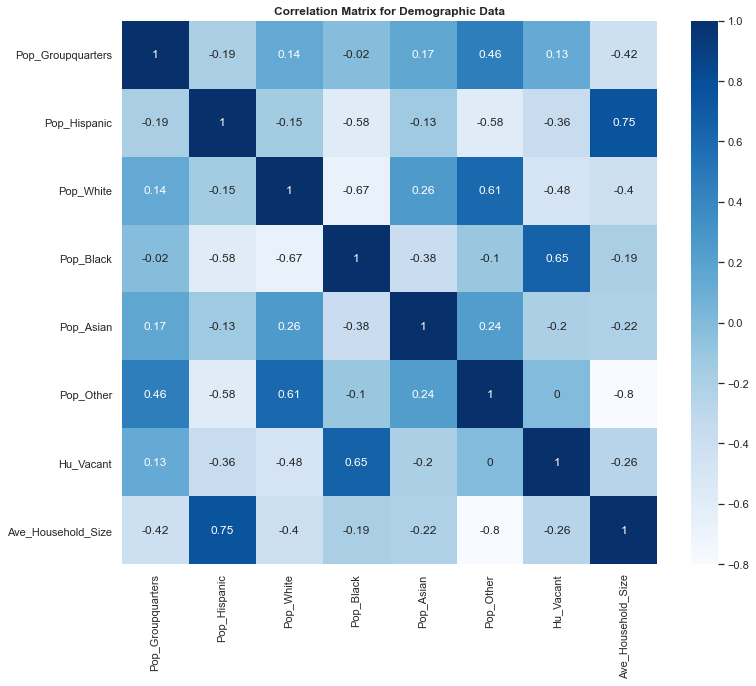

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))
fig = sns.heatmap(df_demog.set_index(['Community_Area_Number',
                                      'Community_Area_Name']).
                  drop(['Pop_Total', 'Housing_Units'], axis=1).
                  corr().round(2), cmap='Blues', annot=True, ax=ax)
fig.set_title('Correlation Matrix for Demographic Data', weight='bold')
plt.show()

Finally, we look at the public health data. One observation that leaps out is the very high correlation between deaths due to homicide, and deaths due to firearms, for obvious reasons.

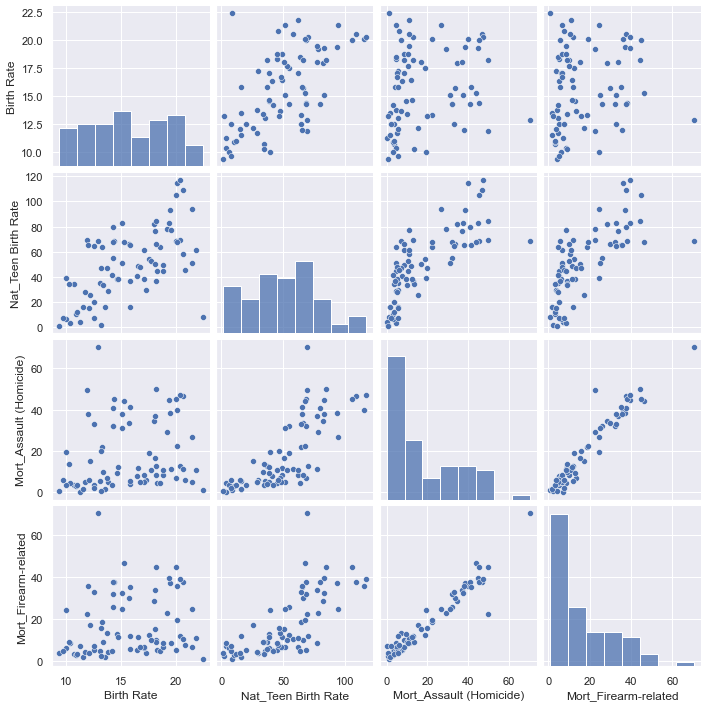

In [23]:
sns.set(style="darkgrid")
sns.pairplot(df_health.set_index(['Community_Area_Number',
                                 'Community_Area_Name']))
plt.show()

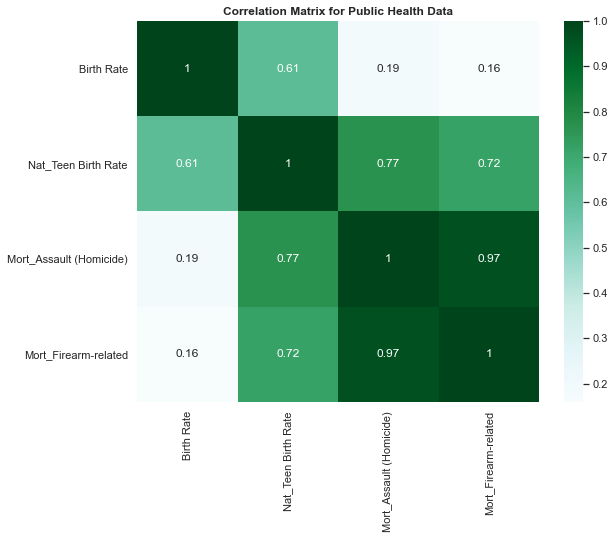

In [24]:
fig, ax = plt.subplots(figsize=(9, 7))
fig = sns.heatmap(df_health.set_index(['Community_Area_Number',
                                      'Community_Area_Name']).
                  corr().round(2), cmap='BuGn', annot=True, ax=ax)
fig.set_title('Correlation Matrix for Public Health Data', weight='bold')
plt.show()

Finally, we summarize the entire features dataset into one correlation heatmap, allowing us to view correlations between individual features across different feature sets. For instance, here we can observe that the proportion of the White population in a community is inversely related to the homicide- and firearm-related deaths.

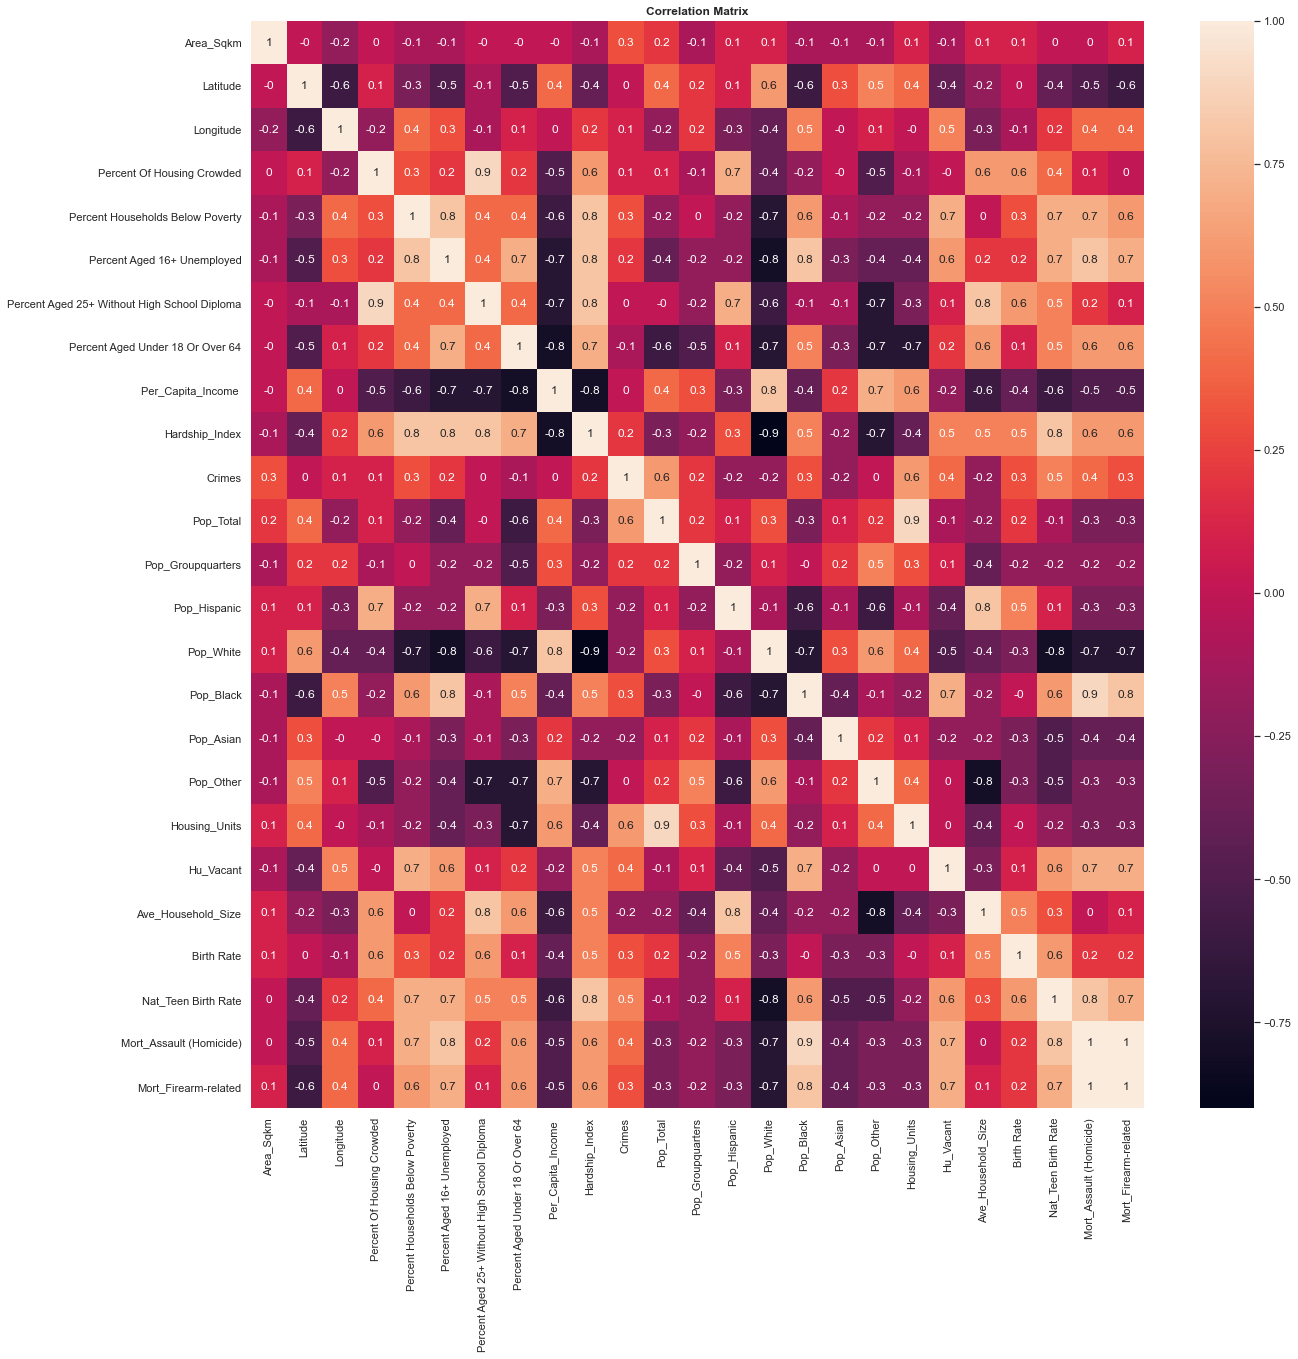

In [25]:
fig, ax = plt.subplots(figsize=(20, 20))
fig = sns.heatmap(df_all.corr().round(1), annot=True, ax=ax)
fig.set_title('Correlation Matrix', weight='bold')
plt.show()

One final consideration is whether to remove features that appear well-correlated with others. Based on trial and error, it appears that removing such features did not materially impact the accuracy of the models, and in some cases led to lower intepretability in the results. Hence the previously constructed design matrix would be kept as is.

### **5.0 Building the Model**

Finally, we proceed to building and training the supervised models. kNN was included for baseline/comparison purposes only, but was deemed unhelpful as it provides no insight as to the top predictors.

In building the model, two modules were relied on heavily: `sklearn.pipeline.Pipeline` and `sklearn.model_selection.GridSearchCV`. These modules were found to have a number of benefits:

- a Pipeline allows for automatic pre-processing of the data (e.g. applying Robust Scaling) with the `fit` methods applied only on the training set, before transforming both training and data sets. This helps to prevent data leakage
- GridSearchCV may be used in conjunction with a cross-validator like RepeatedKFold, simplifying the code
- GridSearchCV also efficiently tunes the hyperparameters and returns a handy table of the different grid search training and test scores, without the need for unwieldy for-loops

Incidentally, the `RepeatedKFold` cross-validator was found to result in a  higher accuracy compared to `KFold`, which yielded negative test accuracy scores when using the setting `shuffle=False`.

It is also worth mentioning that some trial-and-error was done to compare RobustScaler and StandardScaler for the pre-processing pipeline, however there was no significant effect on accuracy. Scaling was not performed for the Decision Tree, Random Forest, or Gradient Boosting Method models, since these methods are scale-invariant.

In [26]:
X = np.array(df_all)
y = np.array(df_targets['Trust_Score'])
feature_names = df_all.columns

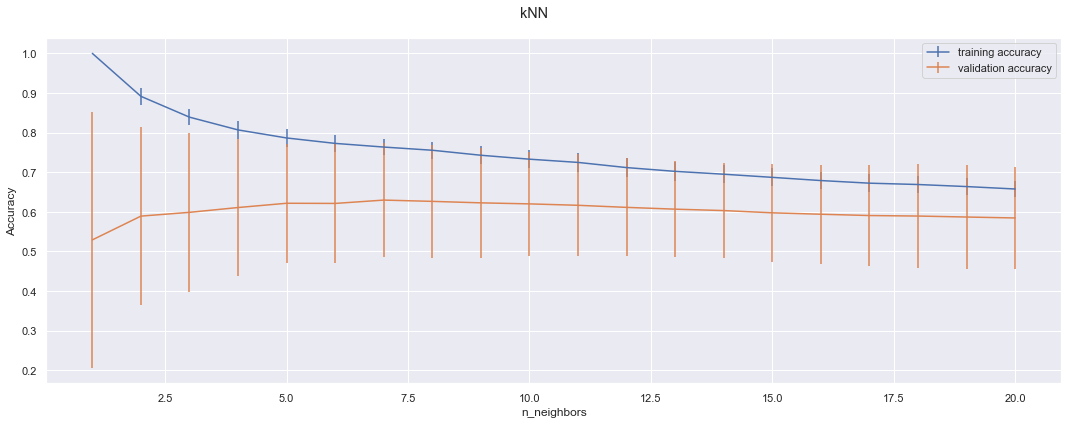

,model_top_parameter,mean_train_score,std_train_score,mean_test_score,std_test_score,top_predictor,run_time
0,'kNN__n_neighbors': 7,0.763452,0.020763,0.629501,0.143224,N/A,13.067384


In [27]:
# kNN

def train_knn():
    start_time = time.time()
    steps = [('scaler', RobustScaler()),
             ('kNN', KNeighborsRegressor())]
    pipeline = Pipeline(steps)

    param_range = range(1, 21)
    params = {'kNN__n_neighbors': param_range}
    model = list(params.keys())[0].split('__')[0]
    hyperparam = list(params.keys())[0].split('__')[1]

    cv = RepeatedKFold(n_splits=6, n_repeats=10, random_state=1)

    grid_search = GridSearchCV(pipeline, refit=True, param_grid=params,
                               cv=cv, return_train_score=True)
    grid_search.fit(X, y)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = (results_df[['params', 'rank_test_score',
                              'mean_train_score', 'std_train_score',
                              'mean_test_score', 'std_test_score']])

    fig = plt.figure(figsize=(15, 6))
    plt.errorbar(param_range, results_df['mean_train_score'],
                  yerr=results_df['std_train_score'], label="training accuracy")
    plt.errorbar(param_range, results_df['mean_test_score'],
                  yerr=results_df['std_test_score'], label="validation accuracy")
    plt.ylabel("Accuracy", fontsize=12)
    plt.xlabel(hyperparam, fontsize=12)
    plt.suptitle(model)
    plt.legend()
    plt.tight_layout()
    plt.show()

    results_df = results_df.sort_values(by=['rank_test_score']).reset_index(drop=True)
    top_result = results_df[:1].copy()
    top_result['params'] = top_result['params'].astype(str).str.extract(r'{(.+)}')
    top_result = top_result.rename(columns={'params': 'model_top_parameter'})
    top_result = top_result.drop(['rank_test_score'], axis=1)
    top_result['top_predictor'] = 'N/A'
    top_result['run_time'] = (time.time() - start_time)
    display(top_result)
    return top_result


knn_results = train_knn()

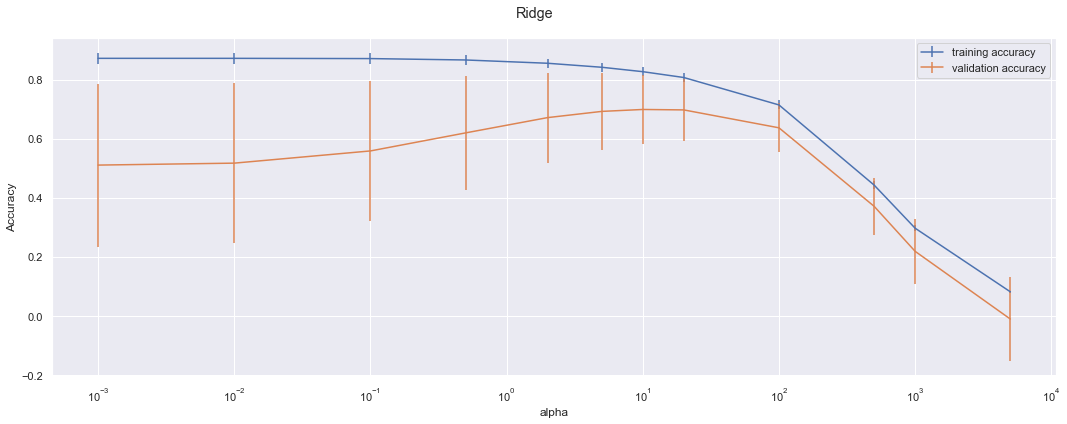

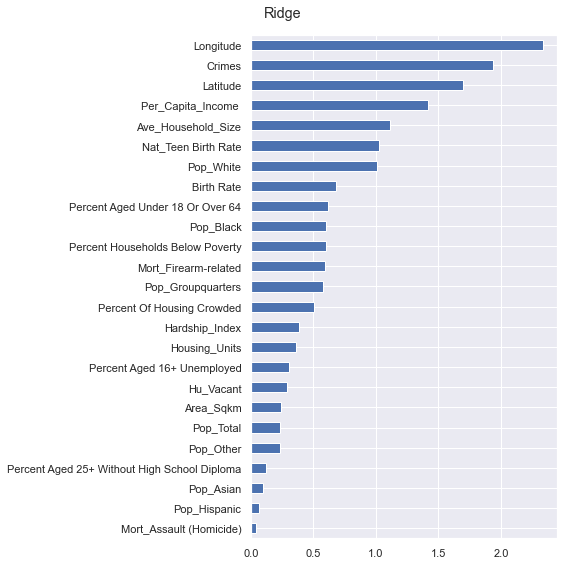

,model_top_parameter,mean_train_score,std_train_score,mean_test_score,std_test_score,top_predictor,run_time
0,'Ridge__alpha': 10,0.826531,0.014934,0.698531,0.115821,Longitude,9.699892


In [28]:
# Ridge

def train_ridge():
    start_time = time.time()
    
    steps = [('scaler', RobustScaler()),
             ('Ridge', Ridge(random_state=1))]
    pipeline = Pipeline(steps)

    param_range = [1e-3, 1e-2, 0.1, 0.5, 2, 5, 10,  20, 100, 500, 1000, 5000]
    params = {'Ridge__alpha': param_range}
    model = list(params.keys())[0].split('__')[0]
    hyperparam = list(params.keys())[0].split('__')[1]

    cv = RepeatedKFold(n_splits=6, n_repeats=10, random_state=1)

    grid_search = GridSearchCV(pipeline, refit=True, param_grid=params,
                               cv=cv, return_train_score=True)
    grid_search.fit(X, y)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = (results_df[['params', 'rank_test_score',
                              'mean_train_score', 'std_train_score',
                              'mean_test_score', 'std_test_score']])

    fig = plt.figure(figsize=(15, 6))
    plt.errorbar(param_range, results_df['mean_train_score'],
                  yerr=results_df['std_train_score'], label="training accuracy")
    plt.errorbar(param_range, results_df['mean_test_score'],
                  yerr=results_df['std_test_score'], label="validation accuracy")
    plt.ylabel("Accuracy", fontsize=12)
    plt.xlabel(hyperparam, fontsize=12)
    plt.xscale('log')
    plt.suptitle(model)
    plt.legend()
    plt.tight_layout()
    plt.show()

    s_predictors = pd.Series(grid_search.best_estimator_.named_steps['Ridge'].coef_).abs()
    s_predictors.index = feature_names
    s_predictors = s_predictors.sort_values()

    fig, ax = plt.subplots(figsize=(8, 8))
    ax = s_predictors.plot(kind='barh')
    plt.suptitle(model)
    plt.tight_layout()
    plt.show()

    results_df = results_df.sort_values(by=['rank_test_score']).reset_index(drop=True)
    top_result = results_df[:1].copy()
    top_result['params'] = top_result['params'].astype(str).str.extract(r'{(.+)}')
    top_result = top_result.rename(columns={'params': 'model_top_parameter'})
    top_result = top_result.drop(['rank_test_score'], axis=1)
    top_result['top_predictor'] = s_predictors.nlargest().index[0]
    top_result['run_time'] = (time.time() - start_time)
    display(top_result)
    return top_result


ridge_results = train_ridge()

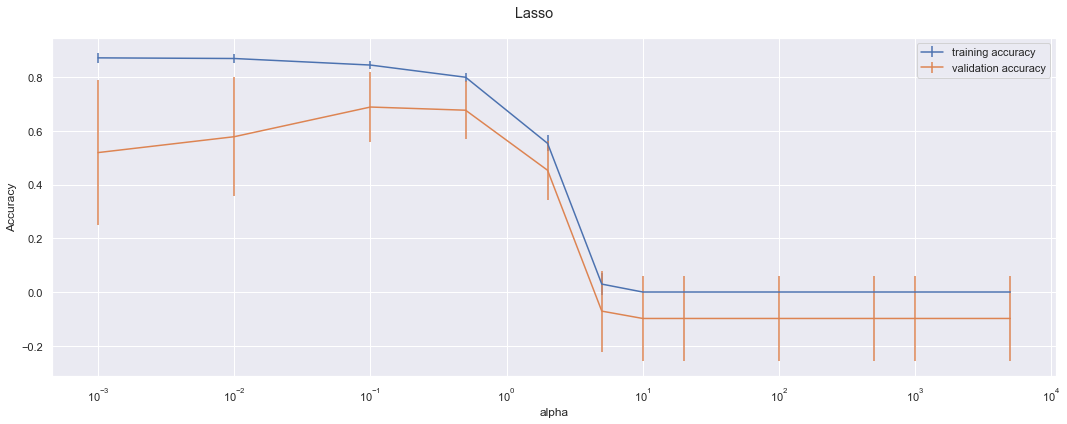

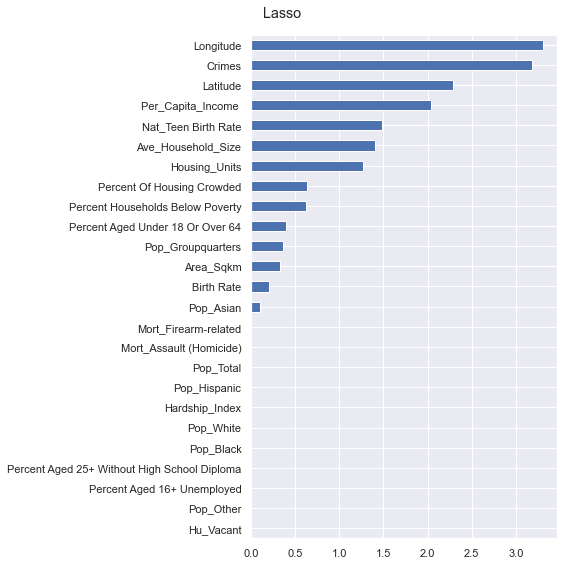

,model_top_parameter,mean_train_score,std_train_score,mean_test_score,std_test_score,top_predictor,run_time
0,'Lasso__alpha': 0.1,0.844904,0.015054,0.688623,0.129807,Longitude,10.290157


In [29]:
# Lasso

def train_lasso():
    start_time = time.time()
    steps = [('scaler', RobustScaler()),
             ('Lasso', Lasso(max_iter=7000, random_state=1))]
    pipeline = Pipeline(steps)

    param_range = [1e-3, 1e-2, 0.1, 0.5, 2, 5, 10,  20, 100, 500, 1000, 5000]
    params = {'Lasso__alpha': param_range}
    model = list(params.keys())[0].split('__')[0]
    hyperparam = list(params.keys())[0].split('__')[1]

    cv = RepeatedKFold(n_splits=6, n_repeats=10, random_state=1)

    grid_search = GridSearchCV(pipeline, refit=True, param_grid=params,
                               cv=cv, return_train_score=True)
    grid_search.fit(X, y)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = (results_df[['params', 'rank_test_score',
                              'mean_train_score', 'std_train_score',
                              'mean_test_score', 'std_test_score']])

    fig = plt.figure(figsize=(15, 6))
    plt.errorbar(param_range, results_df['mean_train_score'],
                  yerr=results_df['std_train_score'], label="training accuracy")
    plt.errorbar(param_range, results_df['mean_test_score'],
                  yerr=results_df['std_test_score'], label="validation accuracy")
    plt.ylabel("Accuracy", fontsize=12)
    plt.xlabel(hyperparam, fontsize=12)
    plt.xscale('log')
    plt.suptitle(model)
    plt.legend()
    plt.tight_layout()
    plt.show()

    s_predictors = pd.Series(grid_search.best_estimator_.named_steps['Lasso'].coef_).abs()
    s_predictors.index = feature_names
    s_predictors = s_predictors.sort_values()

    fig, ax = plt.subplots(figsize=(8, 8))
    ax = s_predictors.plot(kind='barh')
    plt.suptitle(model)
    plt.tight_layout()
    plt.show()

    results_df = results_df.sort_values(by=['rank_test_score']).reset_index(drop=True)
    top_result = results_df[:1].copy()
    top_result['params'] = top_result['params'].astype(str).str.extract(r'{(.+)}')
    top_result = top_result.rename(columns={'params': 'model_top_parameter'})
    top_result = top_result.drop(['rank_test_score'], axis=1)
    top_result['top_predictor'] = s_predictors.nlargest().index[0]
    top_result['run_time'] = (time.time() - start_time)
    display(top_result)
    return top_result


lasso_results = train_lasso()

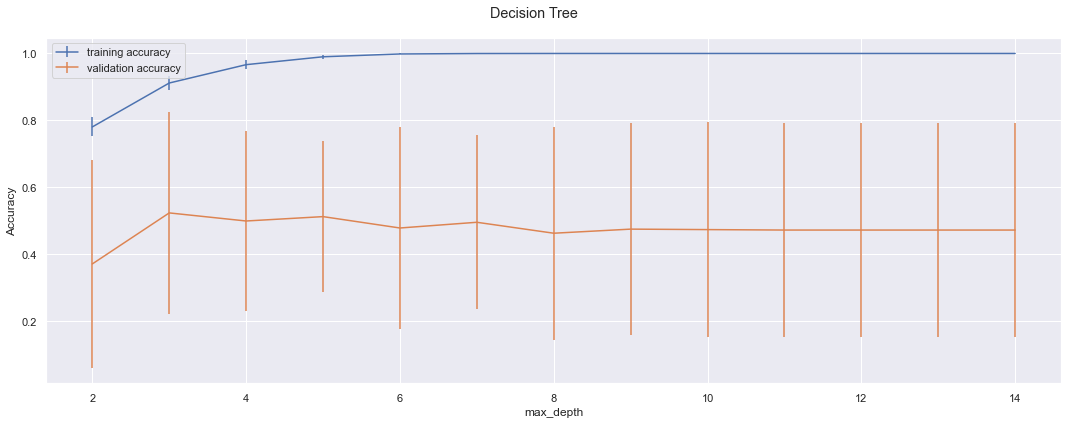

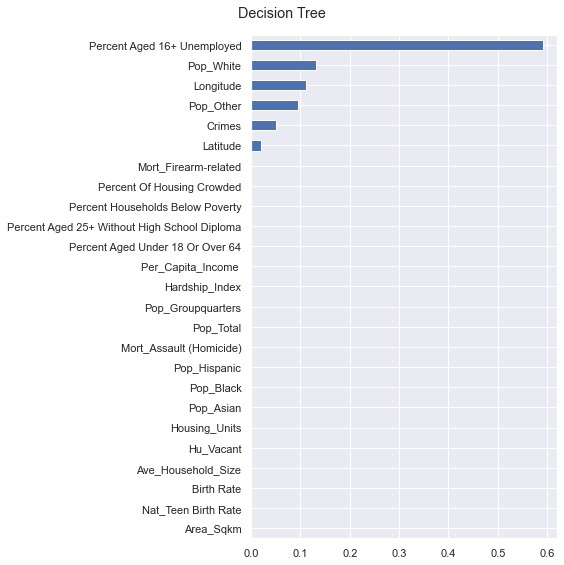

,model_top_parameter,mean_train_score,std_train_score,mean_test_score,std_test_score,top_predictor,run_time
0,'DT__max_depth': 3,0.911734,0.020035,0.523752,0.302555,Percent Aged 16+ Unemployed,3.550092


In [34]:
# Decision Tree

def train_DT():
    start_time = time.time()
    steps = [('DT', DecisionTreeRegressor(random_state=1))]
    pipeline = Pipeline(steps)

    param_range = range(2, 15)
    params = {'DT__max_depth': param_range}
    model = 'Decision Tree'
    hyperparam = list(params.keys())[0].split('__')[1]

    cv = RepeatedKFold(n_splits=6, n_repeats=10, random_state=1)

    grid_search = GridSearchCV(pipeline, refit=True, param_grid=params,
                               cv=cv, return_train_score=True)
    grid_search.fit(X, y)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = (results_df[['params', 'rank_test_score',
                              'mean_train_score', 'std_train_score',
                              'mean_test_score', 'std_test_score']])

    fig = plt.figure(figsize=(15, 6))
    plt.errorbar(param_range, results_df['mean_train_score'],
                  yerr=results_df['std_train_score'], label="training accuracy")
    plt.errorbar(param_range, results_df['mean_test_score'],
                  yerr=results_df['std_test_score'], label="validation accuracy")
    plt.ylabel("Accuracy", fontsize=12)
    plt.xlabel(hyperparam, fontsize=12)
    plt.suptitle(model)
    plt.legend()
    plt.tight_layout()
    plt.show()

    s_predictors = pd.Series(grid_search.best_estimator_
                             .named_steps['DT'].feature_importances_).abs()
    s_predictors.index = feature_names
    s_predictors = s_predictors.sort_values()

    fig, ax = plt.subplots(figsize=(8, 8))
    ax = s_predictors.plot(kind='barh')
    plt.suptitle(model)
    plt.tight_layout()
    plt.show()

    results_df = results_df.sort_values(by=['rank_test_score']).reset_index(drop=True)
    top_result = results_df[:1].copy()
    top_result['params'] = top_result['params'].astype(str).str.extract(r'{(.+)}')
    top_result = top_result.rename(columns={'params': 'model_top_parameter'})
    top_result = top_result.drop(['rank_test_score'], axis=1)
    top_result['top_predictor'] = s_predictors.nlargest().index[0]
    top_result['run_time'] = (time.time() - start_time)
    display(top_result)
    return top_result


DT_results = train_DT()

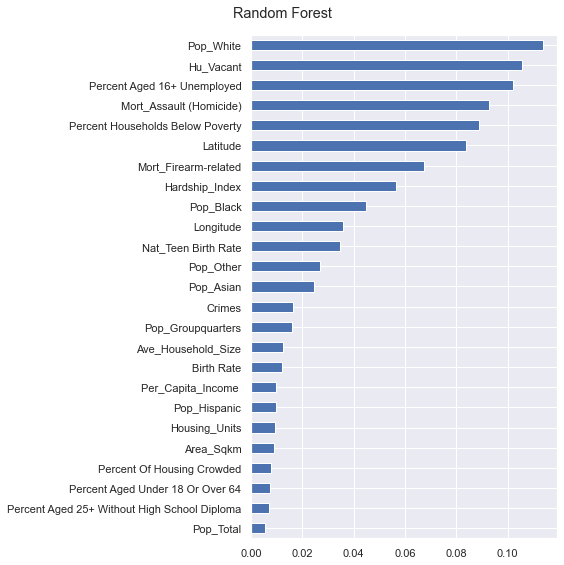

,model_top_parameter,mean_train_score,std_train_score,mean_test_score,std_test_score,top_predictor,run_time
0,"'RF__max_depth': 7, 'RF__max_features': 'sqrt'",0.961069,0.005057,0.703165,0.093861,Pop_White,76.762662


In [35]:
# Random Forest

def train_RF():
    start_time = time.time()
    steps = [('RF', RandomForestRegressor(n_estimators=50, random_state=1))]
    pipeline = Pipeline(steps)

    model = 'Random Forest'
    params = {'RF__max_depth': range(2, 10),
              'RF__max_features': ['sqrt', 'log2', 'auto']}
    cv = RepeatedKFold(n_splits=6, n_repeats=5, random_state=1)

    grid_search = GridSearchCV(pipeline, refit=True, param_grid=params,
                               cv=cv, return_train_score=True)
    grid_search.fit(X, y)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = (results_df[['params', 'rank_test_score',
                              'mean_train_score', 'std_train_score',
                              'mean_test_score', 'std_test_score']])

    s_predictors = pd.Series(grid_search.best_estimator_
                             .named_steps['RF'].feature_importances_).abs()
    s_predictors.index = feature_names
    s_predictors = s_predictors.sort_values()

    fig, ax = plt.subplots(figsize=(8, 8))
    ax = s_predictors.plot(kind='barh')
    plt.suptitle(model)
    plt.tight_layout()
    plt.show()

    results_df = results_df.sort_values(by=['rank_test_score']).reset_index(drop=True)
    top_result = results_df[:1].copy()
    top_result['params'] = top_result['params'].astype(str).str.extract(r'{(.+)}')
    top_result = top_result.rename(columns={'params': 'model_top_parameter'})
    top_result = top_result.drop(['rank_test_score'], axis=1)
    top_result['top_predictor'] = s_predictors.nlargest().index[0]
    top_result['run_time'] = (time.time() - start_time)
    display(top_result)
    return top_result


RF_results = train_RF()

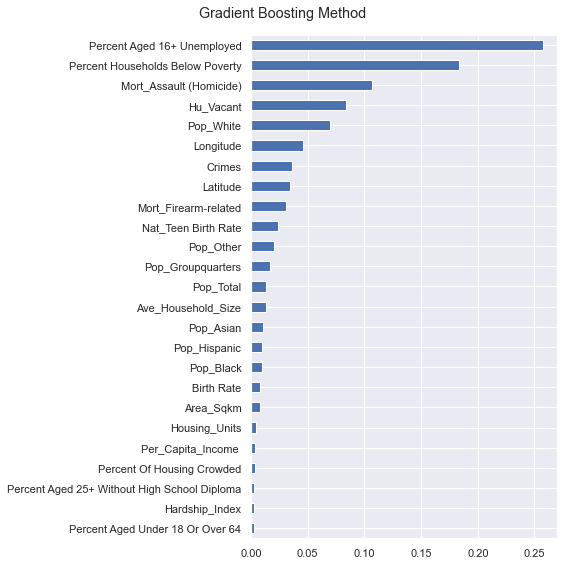

,model_top_parameter,mean_train_score,std_train_score,mean_test_score,std_test_score,top_predictor,run_time
0,"'GB__learning_rate': 0.1, 'GB__max_depth': 4, 'GB__max_features': 0.4",0.999671,0.000082,0.706773,0.150405,Percent Aged 16+ Unemployed,211.3494


In [36]:
# Gradient Boosting Method

def train_GB():
    start_time = time.time()
    steps = [('GB', GradientBoostingRegressor(n_estimators=50, random_state=1))]
    pipeline = Pipeline(steps)

    model = 'Gradient Boosting Method'
    params = {'GB__max_depth': range(2, 7),
              'GB__max_features': [0.2, 0.4, 0.6, 0.8],
              'GB__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2]}
    cv = RepeatedKFold(n_splits=6, n_repeats=10, random_state=1)

    grid_search = GridSearchCV(pipeline, refit=True, param_grid=params,
                               cv=cv, return_train_score=True)
    grid_search.fit(X, y)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = (results_df[['params', 'rank_test_score',
                              'mean_train_score', 'std_train_score',
                              'mean_test_score', 'std_test_score']])

    s_predictors = pd.Series(grid_search.best_estimator_
                             .named_steps['GB'].feature_importances_).abs()
    s_predictors.index = feature_names
    s_predictors = s_predictors.sort_values()

    fig, ax = plt.subplots(figsize=(8, 8))
    ax = s_predictors.plot(kind='barh')
    plt.suptitle(model)
    plt.tight_layout()
    plt.show()

    results_df = results_df.sort_values(by=['rank_test_score']).reset_index(drop=True)
    top_result = results_df[:1].copy()
    top_result['params'] = top_result['params'].astype(str).str.extract(r'{(.+)}')
    top_result = top_result.rename(columns={'params': 'model_top_parameter'})
    top_result = top_result.drop(['rank_test_score'], axis=1)
    top_result['top_predictor'] = s_predictors.nlargest().index[0]
    top_result['run_time'] = (time.time() - start_time)
    display(top_result)
    return top_result


GB_results = train_GB()

### **6.0 Results and Discussion**

In [41]:
summary = pd.concat([knn_results,
                     ridge_results,
                     lasso_results,
                     DT_results,
                     RF_results,
                     GB_results], axis=0)
summary = (summary.drop(['std_train_score', 'std_test_score'], axis=1)
           .set_index('model_top_parameter'))
summary

,mean_train_score,mean_test_score,top_predictor,run_time
model_top_parameter,,,,
'kNN__n_neighbors': 7,0.763452,0.629501,N/A,13.067384
'Ridge__alpha': 10,0.826531,0.698531,Longitude,9.699892
'Lasso__alpha': 0.1,0.844904,0.688623,Longitude,10.290157
'DT__max_depth': 3,0.911734,0.523752,Percent Aged 16+ Unemployed,3.550092
"'RF__max_depth': 7, 'RF__max_features': 'sqrt'",0.961069,0.703165,Pop_White,76.762662
"'GB__learning_rate': 0.1, 'GB__max_depth': 4, 'GB__max_features': 0.4",0.999671,0.706773,Percent Aged 16+ Unemployed,211.349400


Interestingly, different models yielded different rankings of the top predictor variables. While Gradient Boosting Method may be considered the "best" as it yielded the most accurate model, in truth several of the models were close to it in accuracy score, including Linear Regression with Ridge and Lasso regularization, as well as Random Forest. This may be due to the relative small number of observations, and we may see greater accuracy in some of the models, particularly the ensemble decision tree models, with a larger sample size.

Looking at the top models which scored closely on accuracy, I found some roughly common themes. 

Generally, the top predictors of a community’s trust in police are:
- poverty levels, especially in terms of unemployment
- the proportion of the population that are white or Caucasian, indicating that race plays a factor
- the percentage of housing units that remain vacant, which may be an indicator of urban decay
- the per capita number of deaths in the community due to homicide; i.e violence
- and finally, the location in terms of longitude and latitude (in Chicago, the character and makeup of the communities changes, especially as you move eastward approaching the lake and commercial districts)

One learning here is that it helps if the results tell a coherent storyfor the model to be accepted by stakeholders. By this criteria, kNN provides no benefit because it does not yield insight on the predictors. Linear regression with Lasso regulatization on the other hand was useful because it performed feature selection.

### **7.0 Conclusions and Areas for Further Study**

Here, we recap some of the key approaches and insights adopted in the course of this study.

- Since the intent of the study is to understand the drivers of police sentiment scores, there was emphasis on researching and gathering multiple datasets, regarding geography, race, housing, socio-economics, crime volume, and even basic public health indicators on mortality (e.g. violent causes of death) and teen pregnancy. This was cast a wide net on the possible features to consider.  Each dataset needed to be cleaned separately, before incorporating them into the design matrix.
- For the same reason, there is also much importance placed on feature selection and ranking of predictor variables, as well as interpretability.
    - Linear regression with Lasso regularization was especially useful in feature selection.
    - Conversely, kNN was not useful since it does not yield insight on the top predictors.
- Also, with more features to consider, there was more to be done on data exploration. Correlation heatmaps and pairwise scatterplots were particularly useful.
- Since the dataset consists of 77 Community Areas in the city of Chicago, resulting in a limited number of observations, Repeated KFold cross-validation was performed to increase accuracy. Indeed, it resulted in much better accuracy compared to KFold.
    - High values for n_splits was attempted to make the most of each observation, however it was found that n_splits=6 yielded the best results. LOOCV was attempted as well, although it was found to be incompatible with the R-squared scoring.
    - Given there limited number of observations and the emphasis on interpretability, it was decided not to apportion a test set, and rely on validation sets during cross-validation to gauge model accuracy.
- For educational purposes, sklearn.pipeline.Pipeline and sklearn.model_selection.GridSearchCV was studied and used.
    - sklearn.pipeline.Pipeline was used to automate scaling of the test set prior to model training and was shown to be very useful in applying pre-processing steps together with model training, cross-validation, and hyperparamenter tuning, when used in conjunction with GridSearchCV
    - sklearn.model_selection.GridSearchCV was used to tune the model hyperparameters. This was especially useful for Random Forest and Gradient Boosting Method, which have multiple hyperparameters to tune.
- Gradient Boosting Method was the top scorer in terms of accuracy, although several others came quite close.
- Unemployment, race, housing vacancy, community violence, and geography all have a role to play in predicting overall sentiment of a neighborhood in their police force.

Possible future approaches to improve the accuracy of the model might be to perform additional feature engineering, by removing, adding, or combining features, provided that interpretability is maintained. For instance, one might try removing different combinations of the features that have high correlation with other features (this was attempted but not all permutations could be tested). Another possibility is to discard latitude and longitude and see what predictors arise from using linear regression, or remove features that were shown to have low predictive value in the currnt models. It would also be fruitful to train the models using a larger sample size, if similar data can be obtained for other communities in the US and other countries. or in other time periods.